In [1]:
include("..\\Code_jail\\Master_func.jl")

SpecialFunction (generic function with 8 methods)

In [7]:
function standardChop(coeffs, tol = eps())
    # Set default if TOL is not provided
    if isempty(tol)
        tol = eps()
    end
    
    # Check magnitude of TOL
    if tol >= 1
        return 1
    end
    
    # Make sure COEFFS has length at least 17
    n = length(coeffs)
    if n < 17
        return n
    end
    
    # Step 1: Compute ENVELOPE
    b = abs.(coeffs)
    m = fill(b[end], n)
    for j = n-1:-1:1
        m[j] = max(b[j], m[j+1])
    end
    if abs.(m[1]) < 1e-18
        return 1
    end
    envelope = m ./ m[1]
    
    # Step 2: Find PLATEAUPOINT
    plateauPoint = 0
    j2 = 0;
    for j = 2:n
        j2 = round(Int, 1.25*j + 5)
        if j2 > n
            # No plateau: exit
            return n
        end
        e1 = envelope[j]
        e2 = envelope[j2]
        r = 3 * (1 - log(e1) / log(tol))
        plateau = (abs(e1) < 1e-18) || (e2 / e1 > r)
        if plateau
            plateauPoint = j - 1
            break
        end
    end
    
    # Step 3: Determine CUTOFF
    if envelope[plateauPoint] == 0
        return plateauPoint
    else
        j3 = sum(envelope .>= tol^(7/6))
        j2 = min(j3 + 1, j2)
        envelope[j2] = tol^(7/6)
        cc = log10.(envelope[1:j2])
        cc .= cc + range(0,stop=(-1/3)*log10(tol),length=j2)
        d = argmin(cc)
        return max(d - 1, 1)
    end

end

function adaptive_quad(f,Nmax)
    Ns = round.(Int,(1:6) ./ 6 .*Nmax)
    f_ult = [];
    N = 0;
    for NN in Ns
        f_ult = UltraFun(0,f,NN-1);
        N = standardChop(f_ult.c)
        if  N != NN
            break
        end
    end
    if mod(N,2) != 0
        N += 1 
    end
    return f_ult.c[1:min(N,length(f_ult.c))], min(N,length(f_ult.c))
end

adaptive_quad (generic function with 1 method)

# Quadrature
## Trapezoidal
Say we have an equidistant grid $x_i$, the trapezoidal quadrature rule is then given by 
$$
    \int_a^bf(x)\mathrm{d}x= \frac{Δx}{2}\left(f(x_0)+f(x_N)\right)+Δx\sum_{i=1}^{N-1}f(x_i)
$$
Convergence order: $\mathcal{O}(Δx^2)$

Pros: Inexpensive, fast, good for periodic functions 

Cons: Bad at oscillations & singularities, slow convergence

In [8]:
function Trap(f_0,s)
    
    #Good for periodic functions
    
    N = s.N

    f = x-> map(f_0,map(s.c,x))  .* map(s.w,x); # map to real line
    
    dx = (s.b-s.a)/(N);
    
    res = (f(s.a)+f(s.b))/2 * dx
    
    for i1 = 1:N-1
        res += dx * f((s.b-s.a) * i1 / N + s.a)
    end
    
    return res
end

Trap (generic function with 1 method)

In [2]:
f = x -> x.^10 .* exp(-x.^2); true_res = 945*sqrt(π)/32
#a = 100; f = x -> cos(a*x).*exp(-x.^2); true_res = sqrt(pi)*exp(-a^2/4)
s = curv(x -> x, -10,10,x->1,10)

curv(var"#399#401"(), -10, 10, var"#400#402"(), 10, 0, 0)

In [3]:
s = curv(x -> x, -10,10,x->1,5000)
Clen_Curt(f,s) - true_res

-4.476419235288631e-13

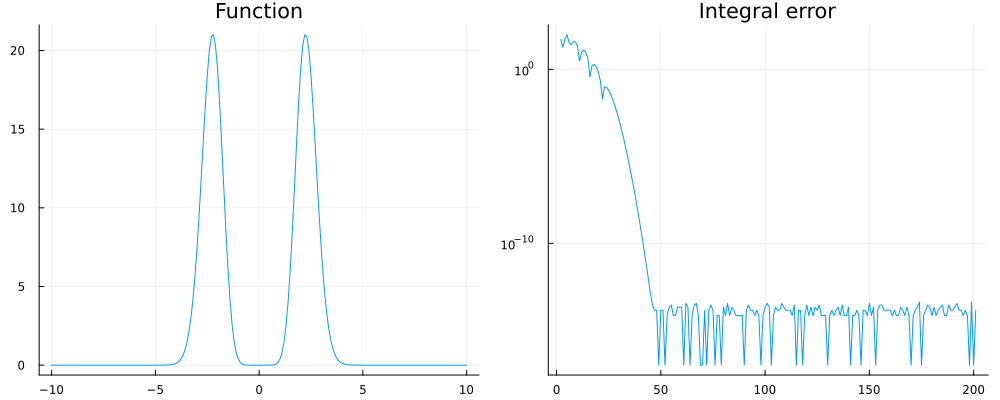

In [5]:
int_err_plot(Trap,f,true_res,s,200)

## Clenshaw-Curtis
In order to get to the Clenshaw-Curtis quadrature method, we change variables $x=\cos(θ)$:
$$
I = \int_{-1}^{1}f(x)\mathrm{d}x = \int_0^π f(\cos(θ))\sin(θ)\mathrm{d}θ.
$$
We can now use the cosine series of $f(\cos(θ))$, with coefficients $a_i,~i\in\mathbb{N}$. We then get that the integral becomes
$$
I≈a_0+\sum_{k=1}^\infty\frac{2a_{2k}}{1-(2k)^2}, \text{ with }a_k=\frac{2}{π}\int_0^π f(\cos(θ))\cos(kθ)\mathrm{d}θ.
$$
You can use a FFT to get the coefficients.

Convergence order: ???

Pros: High accuracy, Suitable for Oscillations (ish), fast-ish.

Cons: Bad with singularities, discontinuities.


In [156]:
function Clen_Curt(f,s)

    f_int = stand_int(f,s);

    (f_coeffs, N) = adaptive_quad(f_int,s.N)
    if s.N == N
        @warn "Maximal amount of quadrature points insufficient: accuracy may be effected."
    end
    N|>display
    n = 0:N/2;
    D = 2 * cos.(2* transpose(n) .* n * pi/N)/N;
    D[1,:] = D[1,:] .* 0.5;
    d = [1; 2 ./ (1 .- (2:2:N).^2)];
    w = D * d;
    x = cos.( (0:N) * π / N );
    w = [w;w[length(w)-1:-1:1]];
    res = sum(map(f_int,x) .* w)
    
    return res
end

Clen_Curt (generic function with 1 method)

In [57]:
function Clen_Curt(f,s)

    if s.N < 4
        s.N = 4
    end

    f_int = stand_int(f,s);

    (f_coeffs, N) = adaptive_quad(f_int,s.N)
    if s.N == N
        @warn "Maximal amount of quadrature points insufficient: accuracy may be effected."
    end

    w = [ k % 2 == 0 ? 2. /(1. - k^2) * sqrt(2.) : 0. for k in 0:(N-1)]
    w[1] = 2;
    w[end-1:end] ./= 2
    
    return dot(w, f_coeffs)
end

Clen_Curt (generic function with 1 method)

In [4]:
int_err_plot(Clen_Curt,f,true_res,s,200)

BoundsError: BoundsError: attempt to access 0-element Vector{Float64} at index [0]

## Modified Filon-Clenshaw-Curtis
Say we want to approximate
$$
\int_0^L f(x)\mathrm{d}x,
$$
where $f$ has a singularity at 0. Subdivide the grid into $M$ intervals bounded by:
$$
x_i = L\left(\frac{i}{M}\right)^q, ~~~ i = 1,\dots,M.
$$
Over interval $[x_i,x_{i+1}], i=1,\dots,M-1$, we use Clenshaw-Curtis. Note that we skip the singularity a tiny bit.

Pros: Deals with Clenshaw Curtis at singularities, so those pros

Cons: There are a lot of variables involved, problematic with oscillations?

In [154]:
function m_Filon_Clen_Curt(f_o,s)

    N = s.N;
    M = s.M;
    q = s.q;

    if mod(N,2) != 0
       N -= 1 
    end
    
    f = x-> map(f_o,map(s.c,x))  .* map(s.w,x); # map to real line

    mua = s.a * ((1:M) ./ M).^q;
    mub = s.b * ((1:M) ./ M).^q;
    
    resa = 0;
    resb = 0;

    for i1 = 1:(M-1)
        sa = curv(x->x,mua[i1],mua[i1+1],x->1,N,M,q)
        sb = curv(x->x,mub[i1],mub[i1+1],x->1,N,M,q)
        resa = resa + Clen_Curt(f,sa);
        resb = resb + Clen_Curt(f,sb);
    end

    if s.a == 0
        resa = 0;
    end
    if s.b == 0
        resb = 0;
    end
    
    res = resb-resa;
    
    return res

end

m_Filon_Clen_Curt (generic function with 1 method)

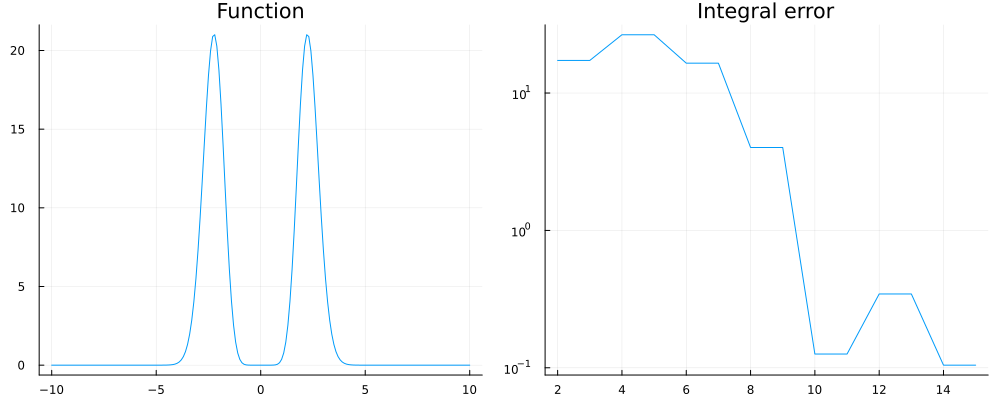

In [155]:
s = curv(x -> x, -10,10,x->1,10,40,210)
int_err_plot(m_Filon_Clen_Curt,f,true_res,s,200)

In [44]:
f = x -> 1
ff = UltraFun(0,f,3)
ff.c|>display

f = x -> x*sqrt(2)
ff = UltraFun(0,f,3)
ff.c|>display

f = x -> cos.(2*acos.(x))*sqrt(2)
ff = UltraFun(0,f,3)
ff.c|>display


4-element Vector{Float64}:
  1.0
  2.498001805406602e-16
 -1.110223024625157e-16
  0.0

4-element Vector{Float64}:
 5.828670879282072e-16
 0.9999999999999997
 1.1102230246251565e-16
 2.554776609266686e-16

4-element Vector{Float64}:
 -6.938893903907228e-16
  2.220446049250313e-15
  0.9999999999999971
 -1.1102230246251565e-16

In [41]:
2/pi|>display

0.6366197723675814

In [42]:
(ff.c[3])^2

0.49999999999999706

In [43]:
1/sqrt(2)

0.7071067811865475